# **Connect to Google Drive**

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


# **Import library**

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model, Input

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
import warnings
warnings.filterwarnings("ignore")

# **Data overview**

In [6]:
path_csv = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data/mushroom_dataset.csv'
df = pd.read_csv(path_csv)
df_plot = df[df.Label != 'EDIBLE']

In [27]:
df['Label'].value_counts()

EDIBLE                               3477
POISONOUS_PLEUROCYBELLA_PORRIGENS     385
POISONOUS_GALERINA_MARGINATA          357
POISONOUS_CORTINARIUS_RUBELLUS        351
POISONOUS_AMANITA_MUSCARIA            341
POISONOUS_CLITOCYBE_DEALBATA          338
POISONOUS_GYROMITRA_ESCULENTA         330
POISONOUS_AMANITA_VIROSA              285
POISONOUS_AMANITA_PHALLOIDES          281
POISONOUS_AMANITA_VERNA               188
POISONOUS_PODOSTROMA_CORNUDAMAE        53
Name: Label, dtype: int64

In [30]:
sns.color_palette("light:b", as_cmap=True)

matplotlib.colors.LinearSegmentedColormap

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

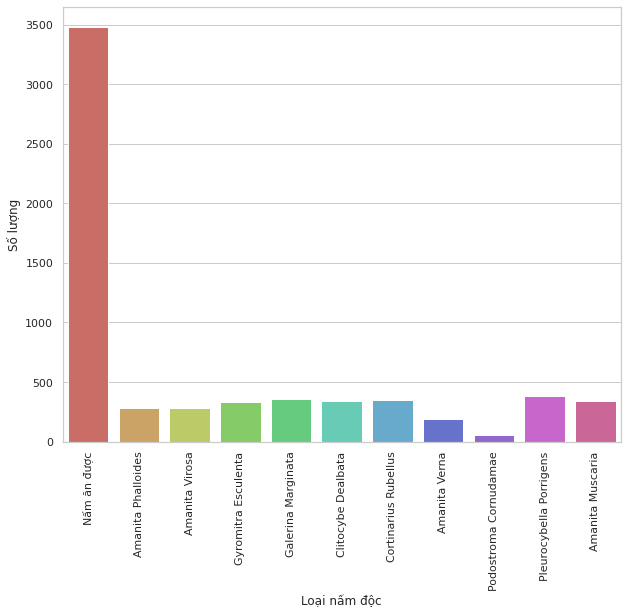

In [42]:
x_ticks = df['Label'].unique()
x_ticks = [i.replace('POISONOUS_', '').replace('_', ' ').lower().title() for i in x_ticks]
x_ticks[0] = 'Nấm ăn được'
sns.set(style="whitegrid", color_codes=True)
class_names = ['Edible', 'Poisonous']
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Label', data=df, palette='hls')
ax.set(xlabel='Loại nấm độc', ylabel='Số lượng')
ax.set_xticklabels(x_ticks)
plt.xticks(rotation=90)

In [17]:
df_plot['Label'].value_counts()

POISONOUS_PLEUROCYBELLA_PORRIGENS    385
POISONOUS_GALERINA_MARGINATA         357
POISONOUS_CORTINARIUS_RUBELLUS       351
POISONOUS_AMANITA_MUSCARIA           341
POISONOUS_CLITOCYBE_DEALBATA         338
POISONOUS_GYROMITRA_ESCULENTA        330
POISONOUS_AMANITA_VIROSA             285
POISONOUS_AMANITA_PHALLOIDES         281
POISONOUS_AMANITA_VERNA              188
POISONOUS_PODOSTROMA_CORNUDAMAE       53
Name: Label, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

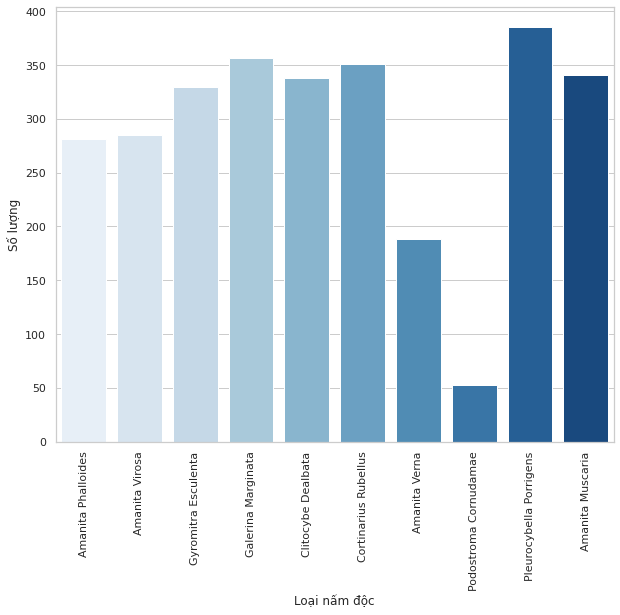

In [33]:
x_ticks = df_plot['Label'].unique()
x_ticks = [i.replace('POISONOUS_', '').replace('_', ' ').lower().title() for i in x_ticks]
sns.set(style="whitegrid", color_codes=True)
class_names = ['Edible', 'Poisonous']
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Label', data=df_plot, palette='Blues')
ax.set(xlabel='Loại nấm độc', ylabel='Số lượng')
ax.set_xticklabels(x_ticks)
plt.xticks(rotation=90)

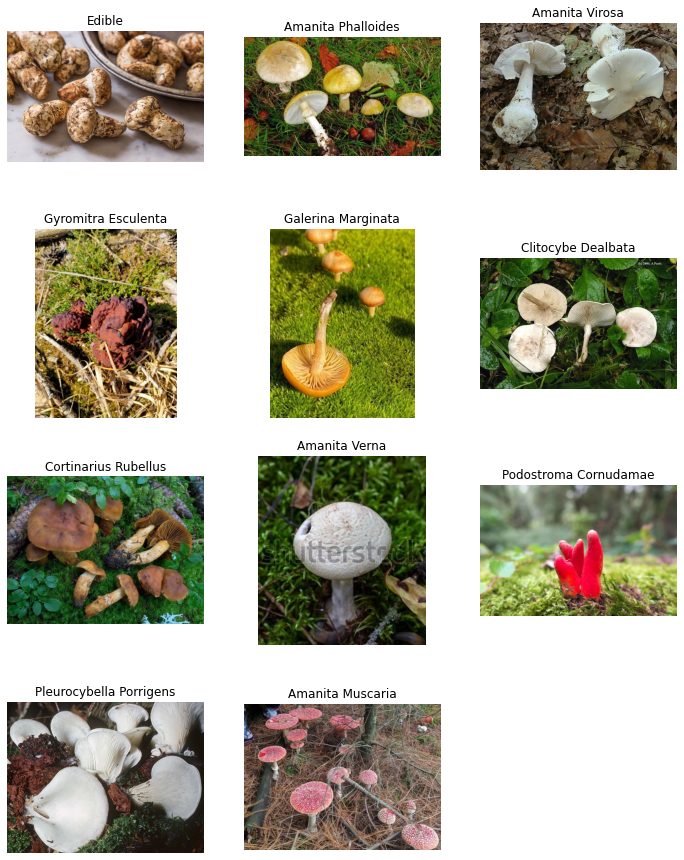

In [7]:
nrows = 4
ncols = 3
position = 0

data_path = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/test'

for subfolder in os.listdir(data_path):
    image_file = os.listdir(os.path.join(data_path, subfolder))[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    position += 1
    sp = plt.subplot(nrows, ncols, position)
    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder.replace('POISONOUS_', '').replace('_', ' ').lower().title())
    plt.axis('Off')

# **Load data**

In [6]:
IMG_SIZE = 227
BATCH_SIZE = 128
IMG_CHANNEL = 3

In [7]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/train',
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True)

dev_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/dev',
                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                   class_mode='categorical',
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True)
                    
test_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/test',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

Found 4589 images belonging to 11 classes.
Found 515 images belonging to 11 classes.
Found 1282 images belonging to 11 classes.


In [ ]:
class_dictionary = test_generator.class_indices
class_names = list(class_dictionary.keys())
class_names = [i.replace('POISONOUS_', '').replace('_', ' ').lower().title() for i in class_names]

# **Model**

In [10]:
def show_accuracy_loss(history):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20, 6))
    for i, item in enumerate(['accuracy', 'loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax = plt.plot(history.history[item])
        ax = plt.plot(history.history['val_'+item])
        plt.title('model '+item)
        plt.ylabel(item)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

## **VGG16**

### **Training**

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNEL))

for layer in vgg.layers:
    layer.trainable = False

flat = Flatten()(vgg.layers[-1].output)
batch = BatchNormalization()(flat)
dense = Dense(256, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(128, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(64, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
output = Dense(11, activation='softmax')(batch)

model = Model(inputs=vgg.inputs, outputs=output)

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 2303s 63s/step - loss: 2.7155 - accuracy: 0.1464 - val_loss: 2.0276 - val_accuracy: 0.4816
Epoch 2/40
36/36 [==============================] - 136s 4s/step - loss: 2.2020 - accuracy: 0.2835 - val_loss: 1.5024 - val_accuracy: 0.6155
Epoch 3/40
36/36 [==============================] - 137s 4s/step - loss: 1.8402 - accuracy: 0.4356 - val_loss: 1.2527 - val_accuracy: 0.6835
Epoch 4/40
36/36 [==============================] - 137s 4s/step - loss: 1.5291 - accuracy: 0.5611 - val_loss: 1.0613 - val_accuracy: 0.7282
Epoch 5/40
36/36 [==============================] - 136s 4s/step - loss: 1.2501 - accuracy: 0.6561 - val_loss: 0.9549 - val_accuracy: 0.7456
Epoch 6/40
36/36 [==============================] - 136s 4s/step - loss: 1.0430 - accuracy: 0.7167 - val_loss: 0.9152 - val_accuracy: 0.7495
Epoch 7/40
36/36 [==============================] - 135s 4s/step - loss: 0.8916 - accuracy: 0.7481 - val_loss: 0.9135 - val_accuracy: 0.7534
Epoch 8/40


### **Save and load**

In [8]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/vgg16.h5'

In [ ]:
model.save(path_model, save_format='h5')

In [9]:
model = keras.models.load_model(path_model)

In [10]:
from keras.preprocessing import image
import numpy as np

path_img = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/test/POISONOUS/114_POISONOUS_PLEUROCYBELLA_PORRIGENS.jpg'
test = image.load_img(path_img, target_size=(227, 227, 3))

x = image.img_to_array(test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

result = model.predict(x)
result

array([[2.8474531e-03, 4.7195729e-04, 1.0766445e-03, 7.6328567e-04,
        2.1131313e-03, 2.7612587e-03, 3.9526992e-04, 4.3531580e-04,
        5.4055545e-04, 9.8642272e-01, 2.1723600e-03]], dtype=float32)

In [15]:
np.sum(result[0])

0.99999994

In [16]:
result_max = np.argmax(result[0], axis=-1)
result_max

9

In [17]:
result[0][result_max]

0.9864227

### **Evaluate**

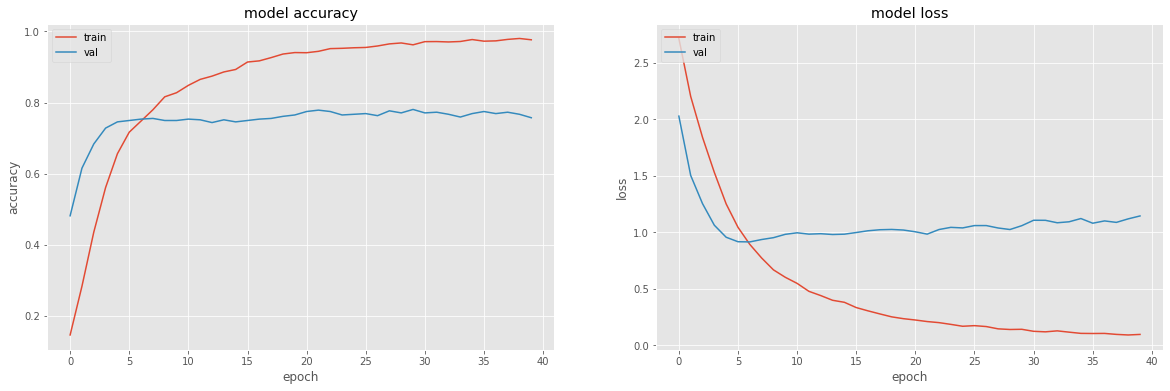

In [ ]:
show_accuracy_loss(history)

In [13]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred_total += y_pred.tolist()
    y_true += np.array(np.argmax(label, axis=-1)).flatten().tolist()

In [14]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.7691
Precision - micro: 0.7691
Precision - macro: 0.7659
Recall - micro: 0.7691
Recall - macro: 0.5919
F1 - micro: 0.7691
F1 - macro: 0.6603


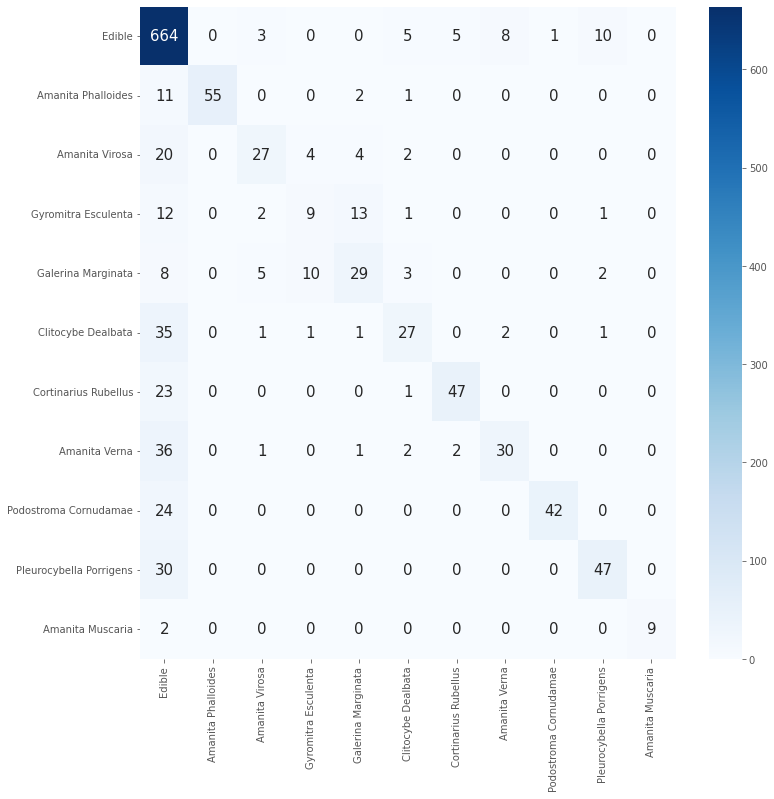

In [ ]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
plt.figure(figsize=(12, 12))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 15})

In [ ]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

                         precision    recall  f1-score   support

                 Edible       0.77      0.95      0.85       696
     Amanita Phalloides       1.00      0.80      0.89        69
         Amanita Virosa       0.69      0.47      0.56        57
    Gyromitra Esculenta       0.38      0.24      0.29        38
     Galerina Marginata       0.58      0.51      0.54        57
     Clitocybe Dealbata       0.64      0.40      0.49        68
   Cortinarius Rubellus       0.87      0.66      0.75        71
          Amanita Verna       0.75      0.42      0.54        72
  Podostroma Cornudamae       0.98      0.64      0.77        66
Pleurocybella Porrigens       0.77      0.61      0.68        77
       Amanita Muscaria       1.00      0.82      0.90        11

               accuracy                           0.77      1282
              macro avg       0.77      0.59      0.66      1282
           weighted avg       0.77      0.77      0.75      1282



## **Resnet50**

### **Training**

In [ ]:
resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNEL))

for layer in resnet.layers:
    layer.trainable = False

flat = Flatten()(resnet.layers[-1].output)
batch = BatchNormalization()(flat)
dense = Dense(256, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(128, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(64, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
output = Dense(11, activation='softmax')(batch)

model = Model(inputs=resnet.inputs, outputs=output)

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 2997s 83s/step - loss: 2.6120 - accuracy: 0.1994 - val_loss: 1.6739 - val_accuracy: 0.5126
Epoch 2/40
36/36 [==============================] - 136s 4s/step - loss: 2.0491 - accuracy: 0.3530 - val_loss: 1.2905 - val_accuracy: 0.6583
Epoch 3/40
36/36 [==============================] - 134s 4s/step - loss: 1.6161 - accuracy: 0.5127 - val_loss: 1.0393 - val_accuracy: 0.7204
Epoch 4/40
36/36 [==============================] - 133s 4s/step - loss: 1.3212 - accuracy: 0.6243 - val_loss: 0.9123 - val_accuracy: 0.7456
Epoch 5/40
36/36 [==============================] - 133s 4s/step - loss: 1.0589 - accuracy: 0.7023 - val_loss: 0.8648 - val_accuracy: 0.7359
Epoch 6/40
36/36 [==============================] - 133s 4s/step - loss: 0.8991 - accuracy: 0.7398 - val_loss: 0.8678 - val_accuracy: 0.7223
Epoch 7/40
36/36 [==============================] - 133s 4s/step - loss: 0.7652 - accuracy: 0.7810 - val_loss: 0.8721 - val_accuracy: 0.7282
Epoch 8/40


### **Save and load**

In [18]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/resnet50.h5'

In [ ]:
model.save(path_model, save_format='h5')

In [19]:
model = keras.models.load_model(path_model)

### **Evaluate**

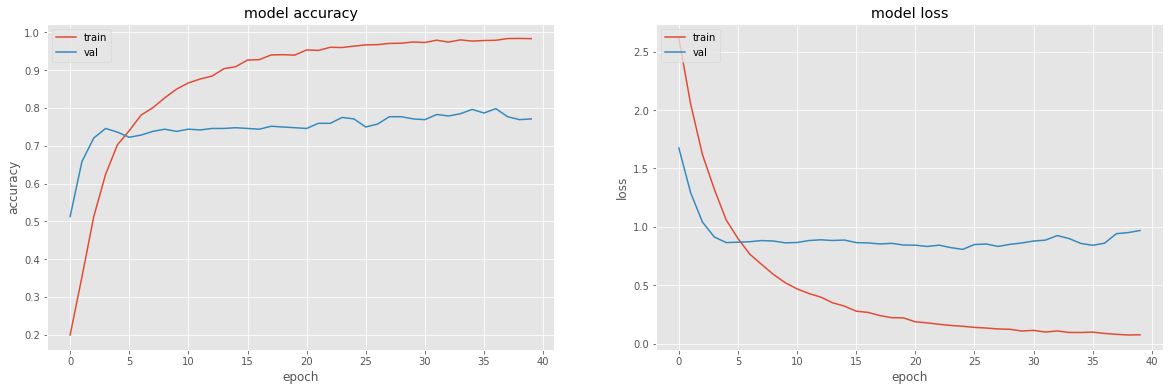

In [ ]:
show_accuracy_loss(history)

In [20]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred_total += y_pred.tolist()
    y_true += np.array(np.argmax(label, axis=-1)).flatten().tolist()

In [21]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.7910
Precision - micro: 0.7910
Precision - macro: 0.7724
Recall - micro: 0.7910
Recall - macro: 0.6073
F1 - micro: 0.7910
F1 - macro: 0.6690


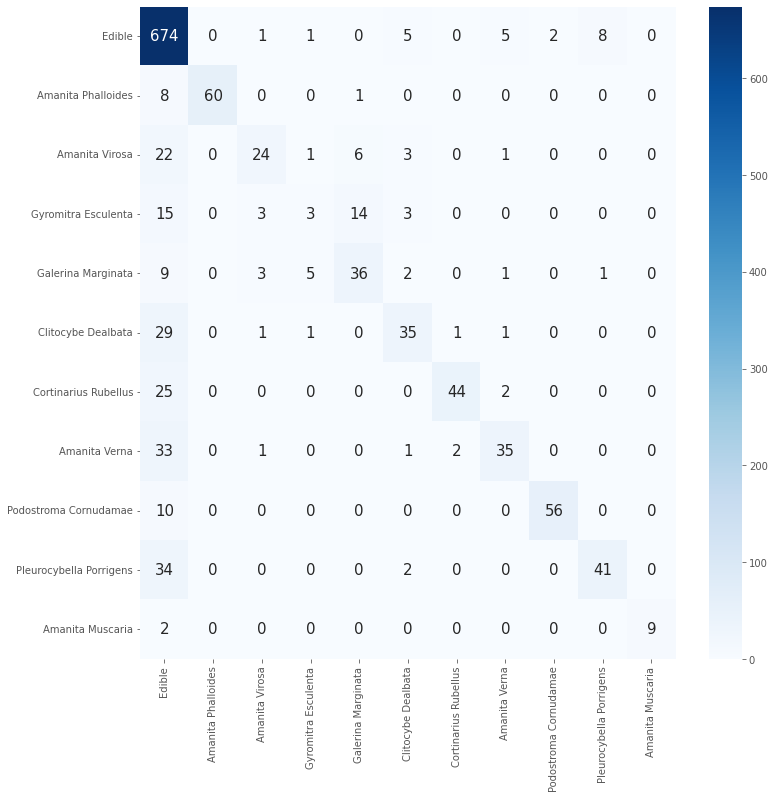

In [ ]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
plt.figure(figsize=(12, 12))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 15})

In [ ]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

                         precision    recall  f1-score   support

                 Edible       0.78      0.97      0.87       696
     Amanita Phalloides       1.00      0.87      0.93        69
         Amanita Virosa       0.73      0.42      0.53        57
    Gyromitra Esculenta       0.27      0.08      0.12        38
     Galerina Marginata       0.63      0.63      0.63        57
     Clitocybe Dealbata       0.69      0.51      0.59        68
   Cortinarius Rubellus       0.94      0.62      0.75        71
          Amanita Verna       0.78      0.49      0.60        72
  Podostroma Cornudamae       0.97      0.85      0.90        66
Pleurocybella Porrigens       0.82      0.53      0.65        77
       Amanita Muscaria       1.00      0.82      0.90        11

               accuracy                           0.79      1282
              macro avg       0.78      0.62      0.68      1282
           weighted avg       0.79      0.79      0.77      1282



## **EfficientNet**

### **Training**

In [11]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

model.trainable = False

x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(11, activation="softmax", name="pred")(x)

model = Model(inputs, outputs, name="EfficientNet")

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 227, 227, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 227, 227, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPa

In [12]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 1454s 40s/step - loss: 2.3427 - accuracy: 0.2929 - val_loss: 1.5977 - val_accuracy: 0.6718
Epoch 2/40
36/36 [==============================] - 141s 4s/step - loss: 1.3920 - accuracy: 0.5725 - val_loss: 1.1968 - val_accuracy: 0.6757
Epoch 3/40
36/36 [==============================] - 141s 4s/step - loss: 1.0127 - accuracy: 0.6917 - val_loss: 1.0060 - val_accuracy: 0.6680
Epoch 4/40
36/36 [==============================] - 141s 4s/step - loss: 0.7843 - accuracy: 0.7640 - val_loss: 0.8906 - val_accuracy: 0.6835
Epoch 5/40
36/36 [==============================] - 141s 4s/step - loss: 0.6716 - accuracy: 0.7997 - val_loss: 0.8008 - val_accuracy: 0.6932
Epoch 6/40
36/36 [==============================] - 141s 4s/step - loss: 0.6046 - accuracy: 0.8156 - val_loss: 0.7192 - val_accuracy: 0.7146
Epoch 7/40
36/36 [==============================] - 141s 4s/step - loss: 0.5506 - accuracy: 0.8278 - val_loss: 0.6465 - val_accuracy: 0.7553
Epoch 8/40


### **Save and load**

In [22]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_species/efficientnet_b0.h5'

In [14]:
model.save(path_model, save_format='h5')

In [23]:
model = keras.models.load_model(path_model)

### **Evaluate**

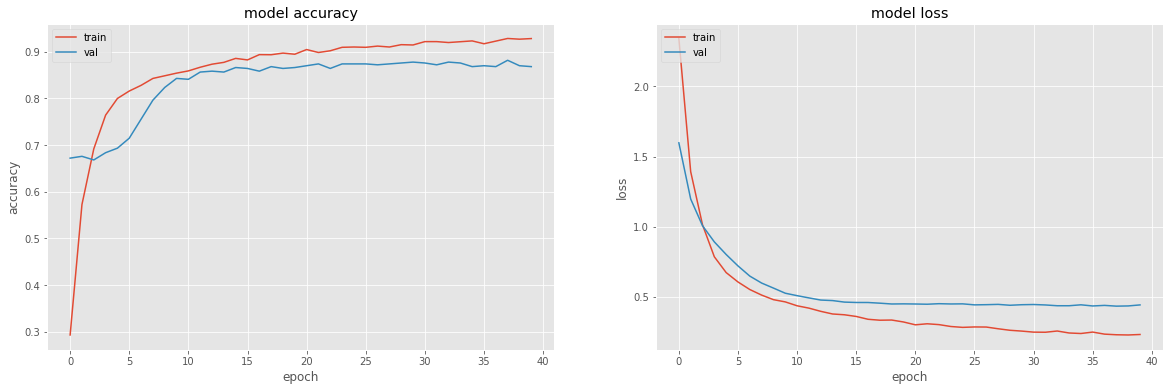

In [15]:
show_accuracy_loss(history)

In [24]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred_total += y_pred.tolist()
    y_true += np.array(np.argmax(label, axis=-1)).flatten().tolist()

In [25]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.8011
Precision - micro: 0.8011
Precision - macro: 0.7771
Recall - micro: 0.8011
Recall - macro: 0.6886
F1 - micro: 0.8011
F1 - macro: 0.7199


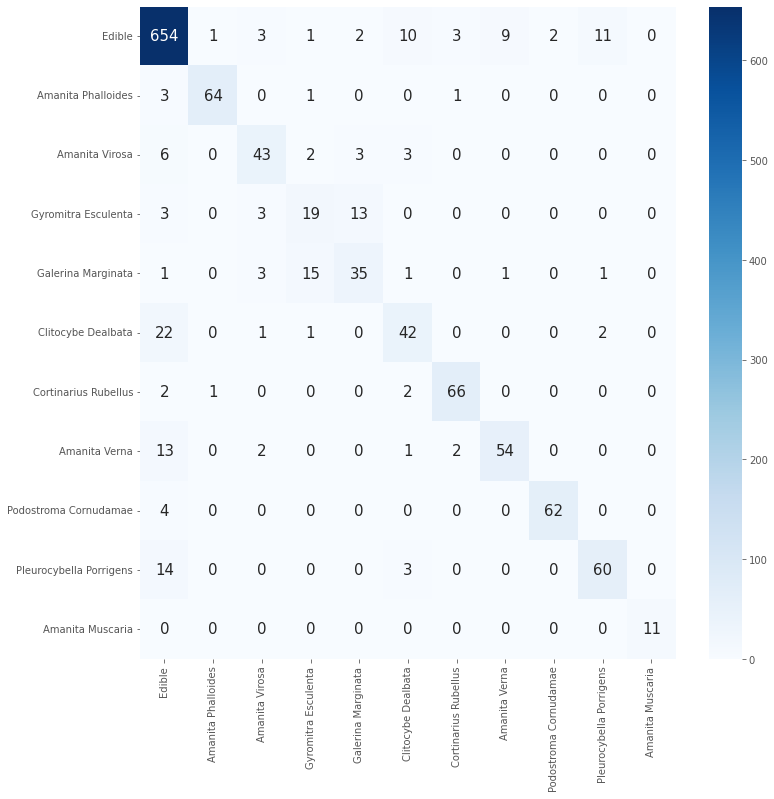

In [18]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
plt.figure(figsize=(12, 12))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 15})

In [19]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

                         precision    recall  f1-score   support

                 Edible       0.91      0.94      0.92       696
     Amanita Phalloides       0.97      0.93      0.95        69
         Amanita Virosa       0.78      0.75      0.77        57
    Gyromitra Esculenta       0.49      0.50      0.49        38
     Galerina Marginata       0.66      0.61      0.64        57
     Clitocybe Dealbata       0.68      0.62      0.65        68
   Cortinarius Rubellus       0.92      0.93      0.92        71
          Amanita Verna       0.84      0.75      0.79        72
  Podostroma Cornudamae       0.97      0.94      0.95        66
Pleurocybella Porrigens       0.81      0.78      0.79        77
       Amanita Muscaria       1.00      1.00      1.00        11

               accuracy                           0.87      1282
              macro avg       0.82      0.80      0.81      1282
           weighted avg       0.86      0.87      0.86      1282

